# Урок 5. Применение математической статистики для проверки гипотез в реальной жизни для популярных метрик

In [1]:
import numpy as np

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm  # будет показывать количество итераций

import warnings
warnings.filterwarnings('ignore')

## Непрерывная метрика

### Задание 1

Мы запустили АБ-тест на увеличение среднего дохода за сеанс. По итогам тестирования мы получили следующие данные. Является ли результат статистически значимым с уровнем доверия 95%? Какую версию мы выкатим в продакшн?

$H_0: \bar{X} - \bar{Y} = 0$ \
$H_1: \bar{X} - \bar{Y} < 0$ – левосторонняя критическая область

Для проверки нулевой гипотезы используют статистический критерий \
$Z = \cfrac{\bar{x}-\bar{y}}{\sqrt{\cfrac{D_x^2}{n}+\cfrac{D_y^2}{m}}}$, где \
$\bar{x}$, $\bar{y}$ - выборочные средние \
$D_x^2$, $D_y^2$ - смещенные выборочные дисперсии (можно использовать и несмещенную)

Для левосторонней критической области. Если $z_н > -z_к$, то гипотеза $H_0$ на уровне значимости $\alpha$ принимается. Если $z_н < -z_к$, то отвергается.

In [2]:
Mx, SDx, Nx = 260, 20, 1000 #A
My, SDy, Ny = 270, 40, 1200 #B
alpha = 0.05

In [5]:
Zk = stats.norm.ppf(1-alpha)
print(f'Zk = {Zk:.2f}')

Zn = (Mx-My)/np.sqrt(SDx**2/Nx + SDy**2/Ny)
print(f'Zn = {Zn:.2f}')

print(f'H0: M(X)=M(Y) is {Zn>-Zk}')

Zk = 1.64
Zn = -7.60
H0: M(X)=M(Y) is False


In [3]:
# Генерируем нормальное распределение на основе введенных данных
X = stats.norm(loc=Mx, scale=SDx).rvs(size=Nx)
Y = stats.norm(loc=My, scale=SDy).rvs(size=Ny)

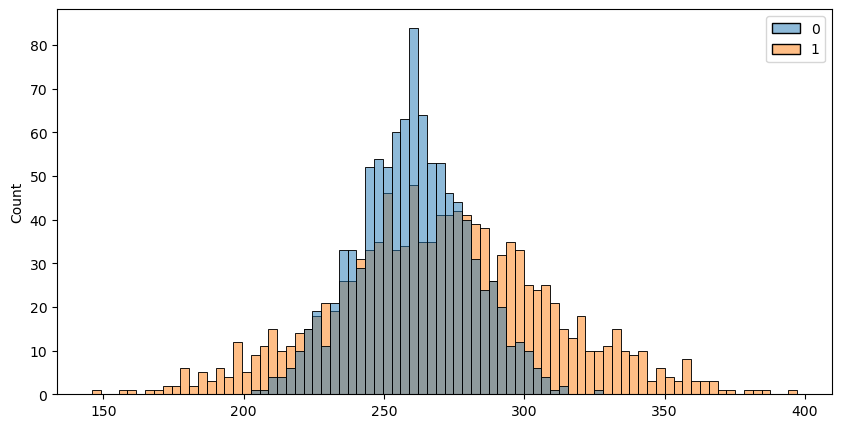

In [4]:
plt.figure(figsize=(10, 5))
sns.histplot([X,Y], bins=80);

In [6]:
# Считаем статистику по выборкам
tvalue, pvalue = stats.ttest_ind(X, Y, equal_var=False, alternative='two-sided')
md = X.mean() - Y.mean()
se = md / tvalue

print(f"Difference between samples: {md}, standart error: {se}, p_value: {pvalue}")
if pvalue < .05:
    print(f'H0: M(X)=M(Y) отвергаем. Обнаружены статистически значимые различия.')
else:
    print(f'H: M(X)=M(Y) принимает. Статистически значимых различий не обнаружено.')

Difference between samples: -10.104624251615803, standart error: 1.2853591289088013, p_value: 6.40989532186809e-15
H0: M(X)=M(Y) отвергаем. Обнаружены статистически значимые различия.


In [7]:
#Простой способ посчитать доверительный интервал
left = md - 1.96 * se
right = md + 1.96 * se

left, right

(-12.623928144277054, -7.585320358954553)

In [8]:
#Через scipy.stats
stats.norm.interval(.95, loc=md, scale=se)

(-12.623881851476831, -7.585366651754776)

In [9]:
#Через бутсрап
def boot (X, Y):
    m = []
    size = max(len(X), len(Y))
    for _ in tqdm(range(1000)):
        c = np.random.choice(X, size=size, replace=True).mean()
        t = np.random.choice(Y, size=size, replace=True).mean()
        m.append(c-t)
    return m

In [10]:
m = boot(X,Y)

  0%|          | 0/1000 [00:00<?, ?it/s]

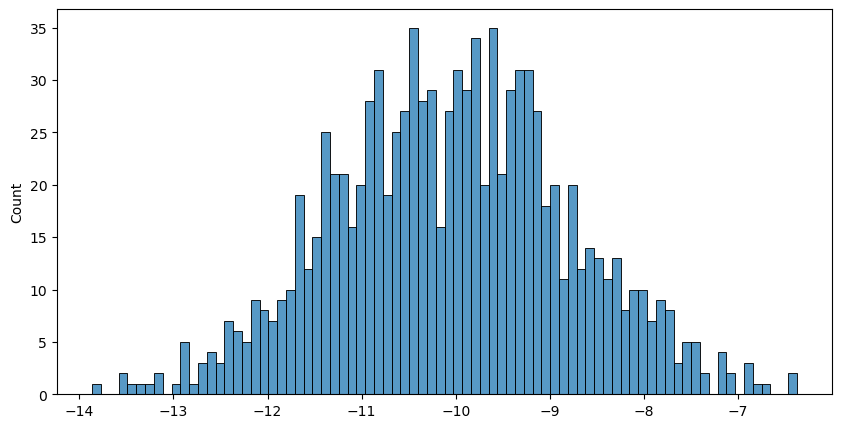

In [11]:
plt.figure(figsize=(10, 5))
sns.histplot(m, bins=80);

In [12]:
np.percentile(m, [2.5, 50, 97.5])

array([-12.43199779, -10.02579008,  -7.66194163])

#### Что если распределение не нормальное?

In [13]:
# Генерируем экспоненциальное распределение на основе введенных данных
X = stats.expon(loc=Mx, scale=SDx).rvs(Nx)
Y = stats.expon(loc=My, scale=SDy).rvs(Ny)

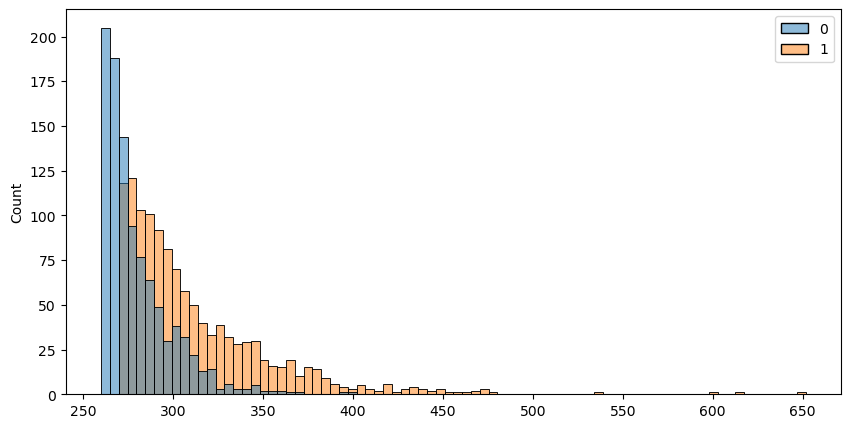

In [14]:
plt.figure(figsize=(10, 5))
sns.histplot([X,Y], bins=80);

In [15]:
# Считаем статистику по выборкам
mwvalue, pvalue = stats.mannwhitneyu(X, Y)

md = X.mean() - Y.mean()
se = md / mwvalue

print(f"Difference between samples: {md}, standart error: {se}, p_value: {pvalue}")
if pvalue < .05:
    print(f'H0: M(X)=M(Y) отвергаем. Обнаружены статистически значимые различия.')
else:
    print(f'H: M(X)=M(Y) принимает. Статистически значимых различий не обнаружено.')

Difference between samples: -31.479609854985767, standart error: -0.00013756105704391158, p_value: 3.9126683755228524e-138
H0: M(X)=M(Y) отвергаем. Обнаружены статистически значимые различия.


In [16]:
# Бутстрап для построения доверительного интервала
m = boot(X,Y)

  0%|          | 0/1000 [00:00<?, ?it/s]

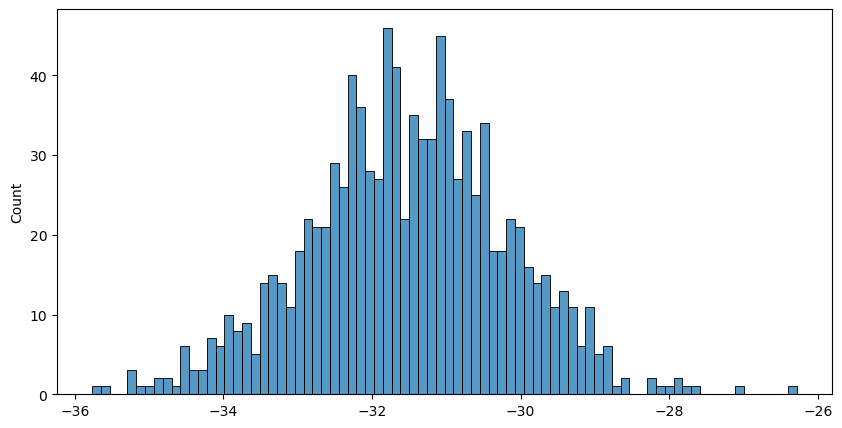

In [17]:
plt.figure(figsize=(10, 5))
sns.histplot(m, bins=80);

In [18]:
np.percentile(m, [2.5, 50, 97.5])

array([-34.1976794 , -31.49999332, -29.02483852])

### Задание 2

Мы провели АБ-тест на увеличение ARPU. По итогам тестирования мы получили следующие данные. Является ли результат статистически значимым с уровнем доверия 95%? Какую версию мы выкатим в продакшн?

$H_0: \bar{X} - \bar{Y} = 0$ \
$H_1: \bar{X} - \bar{Y} \not= 0$ – двусторонняя критическая область

Для проверки нулевой гипотезы используют статистический критерий \
$Z = \cfrac{\bar{x}-\bar{y}}{\sqrt{\cfrac{D_x^2}{n}+\cfrac{D_y^2}{m}}}$, где \
$\bar{x}$, $\bar{y}$ - выборочные средние \
$D_x^2$, $D_y^2$ - смещенные выборочные дисперсии (можно использовать и несмещенную)

Двусторонняя критическая область. Если $|z_н| < z_к$, то гипотеза $H_0$ принимается, в противном случае – отвергается.

In [19]:
Mx, SDx, Nx = 300, 20, 600 #A
My, SDy, Ny = 301, 5, 620 #B
alpha = 0.05

In [20]:
Zk = stats.norm.ppf(1-alpha/2)
print(f'Zk = {Zk:.2f}')

Zn = (Mx-My)/np.sqrt(SDx**2/Nx + SDy**2/Ny)
print(f'Zn = {Zn:.2f}')

print(f'H0: M(X)=M(Y) is {abs(Zn)<Zk}')

Zk = 1.96
Zn = -1.19
H0: M(X)=M(Y) is True


### Задание 3

Мы провели АБ-тест на увеличение average timespent per user. По итогам тестирования мы получили следующие данные. Является ли результат статистически значимым с уровнем доверия 95%? Какую версию мы выкатим на продакшн?

$H_0: \bar{X} - \bar{Y} = 0$ \
$H_1: \bar{X} - \bar{Y} > 0$ – правосторонняя критическая область

Для проверки нулевой гипотезы используют статистический критерий \
$Z = \cfrac{\bar{x}-\bar{y}}{\sqrt{\cfrac{D_x^2}{n}+\cfrac{D_y^2}{m}}}$, где \
$\bar{x}$, $\bar{y}$ - выборочные средние \
$D_x^2$, $D_y^2$ - смещенные выборочные дисперсии (можно использовать и несмещенную)

Правосторонняя критическая область. Если $z_н < z_к$, то гипотеза $H_0$ принимается, в случае $z_н > z_к$ – отвергается.

In [21]:
Mx, SDx, Nx = 478, 20, 92 #A
My, SDy, Ny = 470, 30, 93 #B
alpha = 0.05

In [22]:
Zk = stats.norm.ppf(1-alpha)
print(f'Zk = {Zk:.2f}')

Zn = (Mx-My)/np.sqrt(SDx**2/Nx + SDy**2/Ny)
print(f'Zn = {Zn:.2f}')

print(f'H0: M(X)=M(Y) is {Zn<Zk}')

Zk = 1.64
Zn = 2.14
H0: M(X)=M(Y) is False


### Задание 5

Вычислите  выборочную дисперсию, выборочное  среднее, стандартное отклонение , моду и медиану для следующего множества значений: [5, 5, 5, 18, 10, 8, 9, 10, 19, 21 ]

In [23]:
X = np.array([5, 5, 5, 18, 10, 8, 9, 10, 19, 21])

In [24]:
# несмещенная дисперсия
np.var(X, ddof=1)

37.333333333333336

In [25]:
X.var(ddof=1)

37.333333333333336

In [26]:
np.mean(X)

11.0

In [27]:
X.mean()

11.0

In [28]:
# несмещенное стандартное отклонение
np.std(X, ddof=1)

6.110100926607787

In [29]:
X.std(ddof=1)

6.110100926607787

In [30]:
# мода
stats.mode(X, keepdims=True)[0]

array([5])

In [31]:
# медиана
np.median(X)

9.5

## Метрика пропорций

### Задание 6

Постройте 95% доверительный интервал для  конверсии = 11% с выборкой 1500 человек -  напишите кратко как вы будете интерпретировать результат.

In [32]:
w, n = 0.11, 1500
gamma = 0.95
alpha = 1 - gamma

t = round(stats.t.ppf(1-alpha/2,n-1),2)

print(f'{w - t * np.sqrt(w*(1-w)/n):.3f} < p < {w + t * np.sqrt(w*(1-w)/n):.3f}')

0.094 < p < 0.126


С верояностью 0.95 можно утверждать, что доверительный интервал (0.094;0.126) накроет истинное значение конверсии.

## Практическое задание

Вы провели эксперимент c упрощением формы заказа в магазине Утконос и получили результаты по метрике конверсий в покупку. Выберите метод оценки и оцените есть ли стат.значимые различия между конверсиями в двух группах при alpha = 5%. Дайте краткие рекомендации команде. Результаты:
1) Число юзеров в группах, которые заходили на сайт в период эксперимента: n1 = 15550 и n2 = 15550 \
2) Число юзеров в группах, которые совершили хотя бы одну покупку за период эксперимента: n1 = 164 и n2 = 228 \
3) Конверсии : conv1 = 1.05% conv2 = 1.47%

In [33]:
m1, m2 = 164, 228
n1, n2 = 15500, 15500
p1, p2 = m1/n1, m2/n2
p1, p2

(0.010580645161290323, 0.014709677419354838)

### Распределение Бернулли

In [34]:
X = stats.bernoulli.rvs(p1, size=n1)
Y = stats.bernoulli.rvs(p2, size=n2)

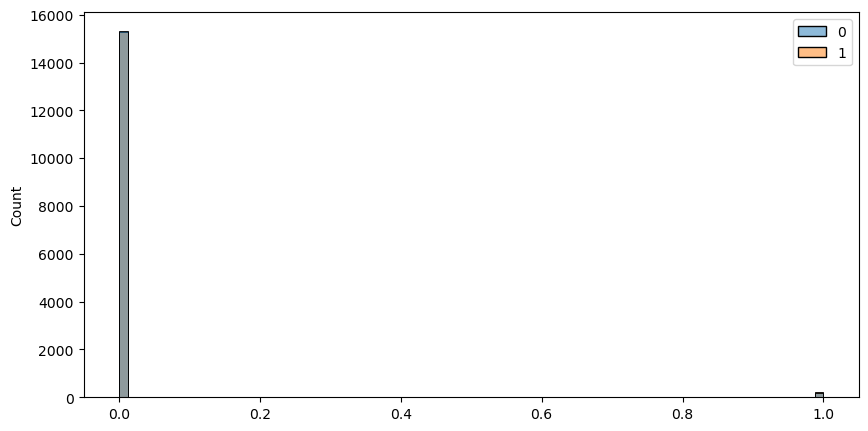

In [35]:
plt.figure(figsize=(10, 5))
sns.histplot([X,Y], bins=80);

In [36]:
# Считаем статистику по выборкам
se = np.sqrt((p1 * (1 - p1) / n1) + (p2 * (1 - p2) / n2))
z_score = (p1 - p2) / se
pvalue = stats.norm.sf(abs(z_score)) * 2

md = p1 - p2

print(f"Difference between samples: {md}, standart error: {se}, p_value: {pvalue}")
if pvalue < .05:
    print(f'H0: p1=p2 отвергаем. Обнаружены статистически значимые различия.')
else:
    print(f'H: p1=p2 принимает. Статистически значимых различий не обнаружено.')

Difference between samples: -0.004129032258064515, standart error: 0.0012690356490794444, p_value: 0.0011392168150319737
H0: p1=p2 отвергаем. Обнаружены статистически значимые различия.


In [37]:
# Считаем доверительный интервал
left = md - 1.96 * se
right = md + 1.96 * se

left, right

(-0.006616342130260227, -0.0016417223858688043)